In [1]:
!pip install git+https://github.com/IBM/tsfm.git transformers

  Cloning https://github.com/IBM/tsfm.git to /tmp/pip-req-build-f1ni8edg
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/tsfm.git /tmp/pip-req-build-f1ni8edg
  Resolved https://github.com/IBM/tsfm.git to commit 879c707b082a7b2a9dbf994aec4e53f9e2dec808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.0-py3-none-any.whl size=2303294 sha256=b0c0cf2e174deeec226cf8bc22c6a3df0b855cc7c7a10a47e9e078d92924d769
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3rxp6hh/wheels/5a/6f/47/d5b39e2ef02fcf2babe83b47c59d429538120556b0bde4cb43
Successfully built tsfm_public


In [2]:
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

2024-06-06 07:38:16.569835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 07:38:16.570131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 07:38:16.742174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


dataset_path = "../input/timeseries/finalData.csv"
timestamp_column = "Date"
id_columns = []

context_length = 512
forecast_horizon = 96
patch_length = 8
num_workers = 16  
batch_size = 64  
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
forecast_columns = list(data.columns[1:])

In [4]:
# TimeSeriesSplit ile çapraz doğrulama
tscv = TimeSeriesSplit(n_splits=5)

# Performans grafikleri için depolar
losses = []

# Tahminler ve gerçek değerleri karşılaştıran grafikler için fonksiyon
def plot_predictions_vs_actuals(trainer, test_dataset, num_steps=100):
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions
    labels = predictions.label_ids

    # Tahminler ve etiketlerin boyutlarını ve yapılarını kontrol et
    print(f"Predictions: {type(preds)} {len(preds)} {preds[0].shape}")
    print(f"Labels: {type(labels)} {len(labels)} {labels.shape}")

    # predictions ve labels'i uygun boyutlara getir
    preds = np.vstack([p.squeeze() if p.ndim == 3 else p.reshape(-1, 18) for p in preds])
    labels = labels.squeeze()
    
    # TSLA High değerine ait gerçek vs tahmin grafiği çiz
    plt.figure(figsize=(12, 6))
    plt.plot(labels[:num_steps, 0], label="Gerçek Değerler")
    plt.plot(preds[:num_steps, 0], label="Tahminler", linestyle='dashed')
    plt.title('TSLA High İçin Gerçek vs. Tahmin')
    plt.xlabel('Zaman Adımları')
    plt.ylabel('TSLA High')
    plt.legend()
    plt.show()

Fold 1


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3

Epoch,Training Loss,Validation Loss
1,0.481400,2.522727


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

Predictions: <class 'tuple'> 4 (1, 96, 18)
Labels: <class 'numpy.ndarray'> 1 (1, 96, 18)


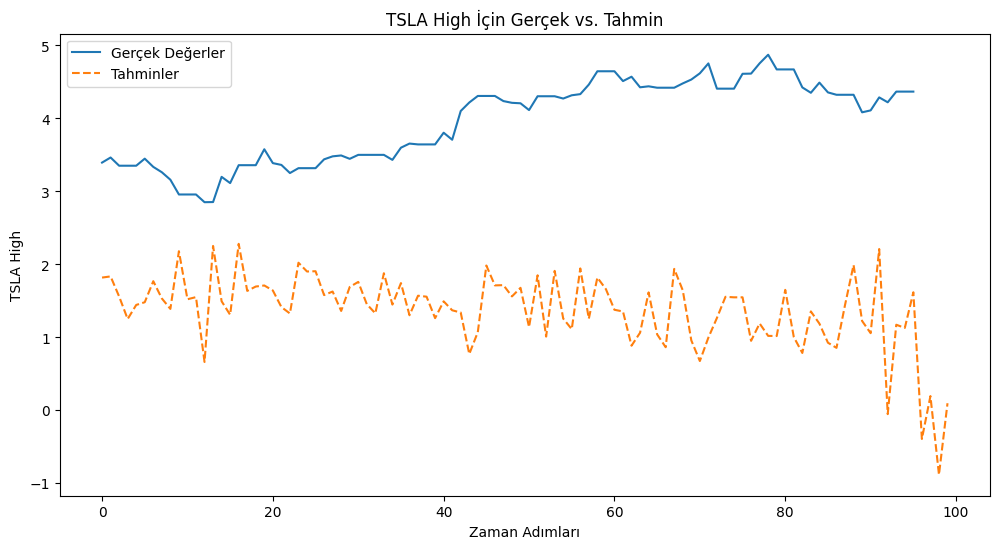

Fold 2


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3

Epoch,Training Loss,Validation Loss
1,0.640400,0.305225


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

Predictions: <class 'tuple'> 4 (1, 96, 18)
Labels: <class 'numpy.ndarray'> 1 (1, 96, 18)


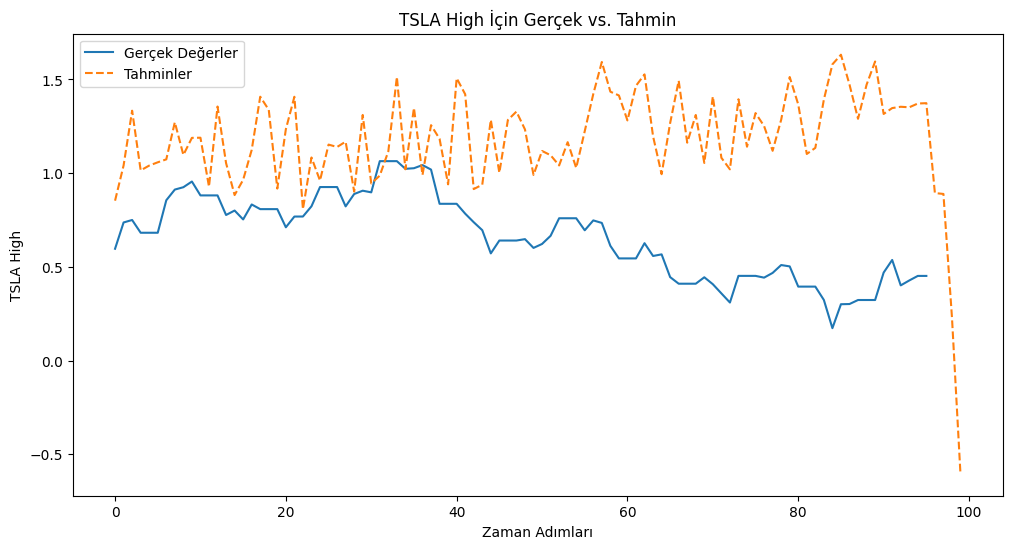

Fold 3


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3

Epoch,Training Loss,Validation Loss
1,0.488600,0.146743


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

Predictions: <class 'tuple'> 4 (1, 96, 18)
Labels: <class 'numpy.ndarray'> 1 (1, 96, 18)


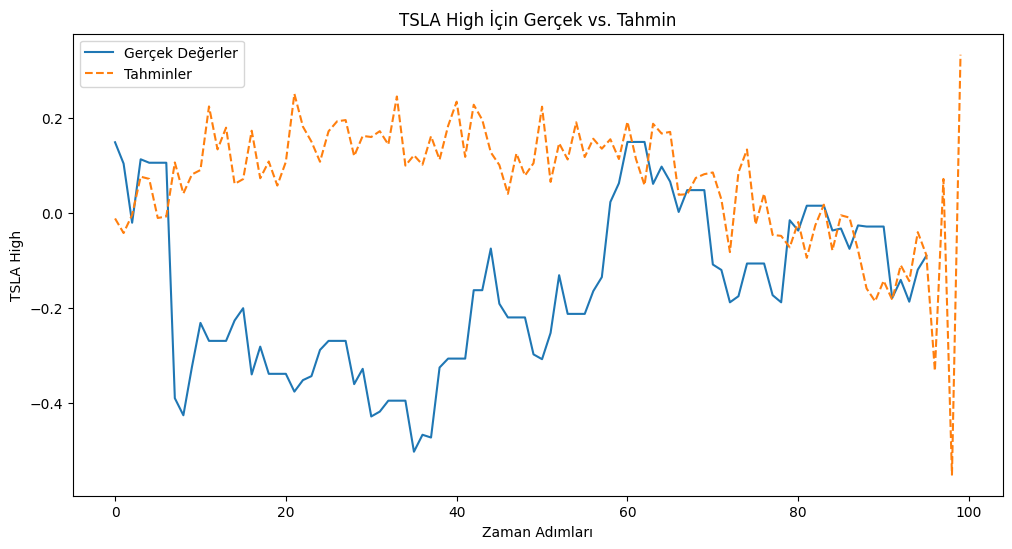

Fold 4


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3

Epoch,Training Loss,Validation Loss
1,0.398100,0.094065


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

Predictions: <class 'tuple'> 4 (1, 96, 18)
Labels: <class 'numpy.ndarray'> 1 (1, 96, 18)


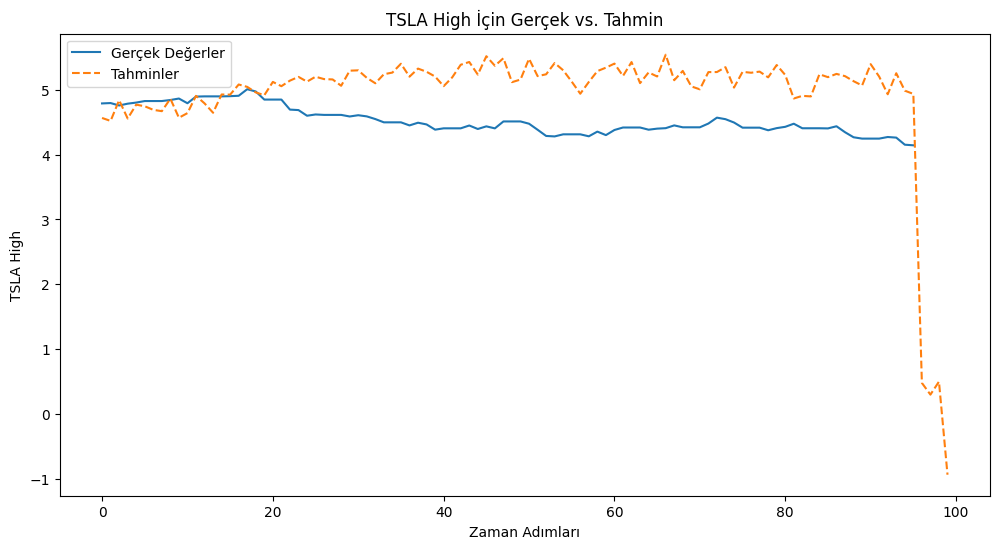

Fold 5


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3

Epoch,Training Loss,Validation Loss
1,0.343000,0.400808


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

Predictions: <class 'tuple'> 4 (1, 96, 18)
Labels: <class 'numpy.ndarray'> 1 (1, 96, 18)


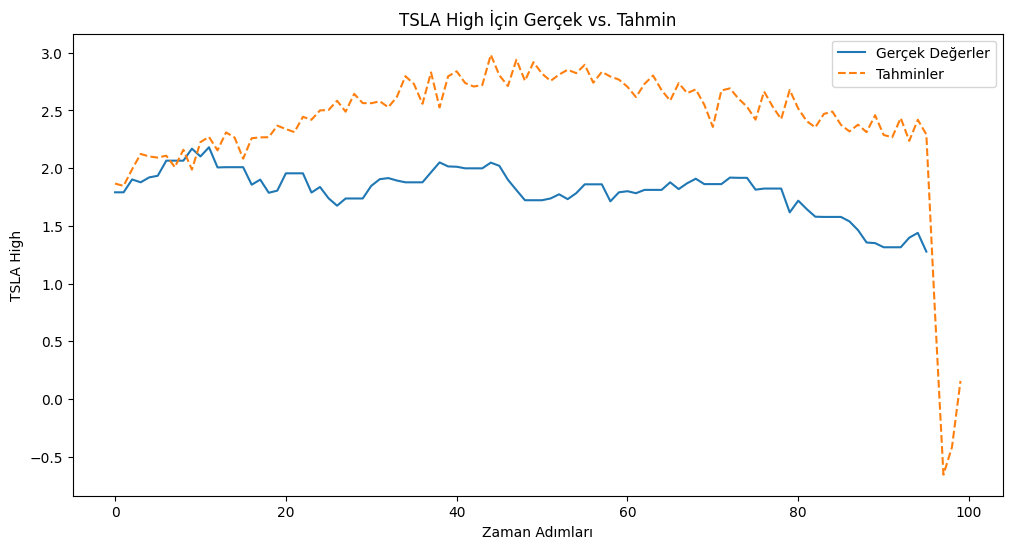

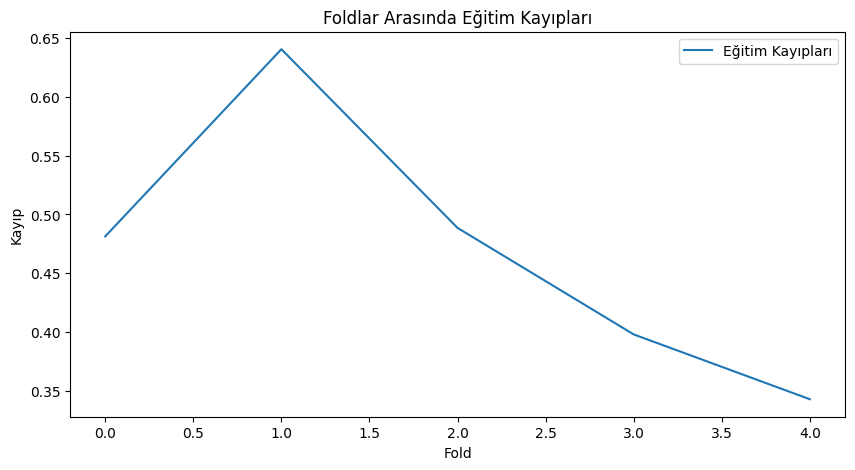

In [5]:

for fold, (train_index, test_index) in enumerate(tscv.split(data)):
    print(f"Fold {fold + 1}")
    
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    
    num_valid = int(len(test_data) * 0.5)
    valid_data = test_data.iloc[:num_valid]
    test_data = test_data.iloc[num_valid:]
    
    tsp = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        id_columns=id_columns,
        target_columns=forecast_columns,
        scaling=True,
    )
    tsp.train(train_data)
    
    train_dataset = ForecastDFDataset(
        tsp.preprocess(train_data),
        id_columns=id_columns,
        timestamp_column="Date",
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )
    valid_dataset = ForecastDFDataset(
        tsp.preprocess(valid_data),
        id_columns=id_columns,
        timestamp_column="Date",
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )
    test_dataset = ForecastDFDataset(
        tsp.preprocess(test_data),
        id_columns=id_columns,
        timestamp_column="Date",
        target_columns=forecast_columns,
        context_length=context_length,
        prediction_length=forecast_horizon,
    )
    
    config = PatchTSMixerConfig(
        context_length=context_length,
        prediction_length=forecast_horizon,
        patch_length=patch_length,
        num_input_channels=len(forecast_columns),
        patch_stride=patch_length,
        d_model=16,
        num_layers=8,
        expansion_factor=2,
        dropout=0.2,
        head_dropout=0.2,
        mode="common_channel",
        scaling="std",
    )
    
    model = PatchTSMixerForPrediction(config)
    training_args = TrainingArguments(
        output_dir=f"./checkpoint/patchtsmixer/electricity/pretrain/output/fold_{fold + 1}/",
        overwrite_output_dir=True,
        learning_rate=0.001,
        num_train_epochs=1,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        report_to="tensorboard",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir=f"./checkpoint/patchtsmixer/electricity/pretrain/logs/fold_{fold + 1}/",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        label_names=["future_values"],
    )
    
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.0001,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback],
    )
    
    training_output = trainer.train()
    losses.append(training_output.training_loss)
    
    # Tahminler ve gerçek değerler karşılaştırma grafiği çiz
    plot_predictions_vs_actuals(trainer, test_dataset)

# Toplam kayıp eğrisini çiz
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Eğitim Kayıpları')
plt.xlabel('Fold')
plt.ylabel('Kayıp')
plt.title('Foldlar Arasında Eğitim Kayıpları')
plt.legend()
